# Spatial Analysis Notebook: One polygon

The purpose of this code is to create a set of graphs based on one shapefile and one polygon.  This code was used to conduct preliminary analysis of case studies, but does not produce any specific figures in the paper.  It is provided in case others would like to conduct a drought analysis on a specific area.

To run this code, you need the following files in the appropriate folders:
 - Data/Output/Local
   - Master_ADWR_database_noduplicates.shp
   - Master_ADWR_database_water.shp
   - Wells55_GWSI_WLTS_DB_annual_updated.csv
 - Data/Input/Shapefiles
   - Any shapefiles of your choosing

In [5]:
# Packages and paths
# %%
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import geopandas as gp
import scipy.stats as sp
import sys

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/Local/'


Providing colors

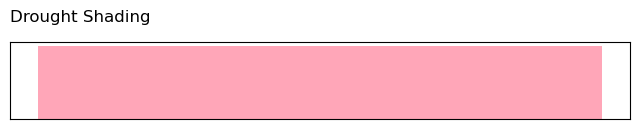

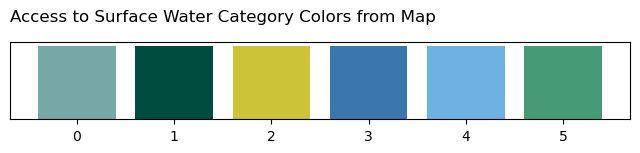

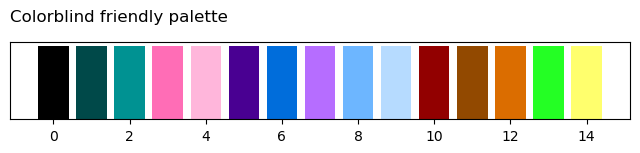

In [6]:
# %% Creating colors
drought_color = '#ffa6b8'

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Colors from map
cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map in the trend paper
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'
a2sw_colors =[cap,cap_secondary,noCAP,GWdom,mixed,swdom]

# Create a bar plot to visualize colors
palette = [drought_color]
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Drought Shading',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
ax.set_xticks([])
plt.show()

palette = a2sw_colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Access to Surface Water Category Colors from Map',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

palette = cblind
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Colorblind friendly palette',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

Read in the main databases.  You only have to do this once.

Master Database might take a while (~5-7 minutes).

In [3]:
# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)
print(filepath)

masterdb = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb.info())

../../Data/Output/Local/Master_ADWR_database_noduplicates.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 255849 entries, 0 to 255848
Data columns (total 80 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Combo_ID    255849 non-null  object        
 1   OBJECTID_g  45684 non-null   float64       
 2   SITE_ID     45684 non-null   object        
 3   LOCAL_ID    45684 non-null   object        
 4   REGISTRY_I  234704 non-null  object        
 5   WELL_TYPE   45684 non-null   object        
 6   DD_LAT      45684 non-null   float64       
 7   DD_LONG     45684 non-null   float64       
 8   LAT_NAD27   45684 non-null   object        
 9   LONG_NAD27  45684 non-null   object        
 10  WELL_ALT    45684 non-null   float64       
 11  WATER_USE_  45626 non-null   object        
 12  WELL_DEPTH  215436 non-null  float64       
 13  CASE_DIAM   33813 non-null   float64       
 14  WL_COUNT    45684 non-null   f

In [24]:
# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py

# filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated.csv'
filename_ts = 'Wells55_GWSI_WLTS_DB_monthly.csv'
filepath = os.path.join(outputpath, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

#Block to do some formatting
annual_db = annual_db[1:168102]
annual_db.index = annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'date':'Combo_ID'})
annual_db2.head()

../../Data/Output/Local/Wells55_GWSI_WLTS_DB_monthly.csv


,Combo_ID,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,...,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,nan
0,60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,82721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2,83226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.00
3,83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,83716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00


### From here down is where you can rerun the code to generate graphs

In [7]:
# Read in the reach shapefile

# filename_shapeile = 'georeg_reproject_fixed.shp'
# filename_shapeile = '/flowlines_order4plus.shp'
filename_shapeile = '/huc12flowlines_order3plus.shp'
# filepath = os.path.join(shapepath, filename_shapeile)
filepath = os.path.join(outputpath+filename_shapeile)
shapefile = gp.read_file(filepath)
# shapefile.plot(cmap='viridis')


Take a look at the columns and variables

In [8]:
shapefile

,permanent_,gnis_name,reachcode,streamorde,ID,huc12,huc_name,fcode,geometry
0,149136270,Dodson Wash,15020005000065,5,None,150200050309,Dodson Wash,46003,"LINESTRING Z (-110.22189 34.34674 0, -110.2217..."
1,149136272,Dodson Wash,15020005000066,5,None,150200050309,Dodson Wash,46003,"LINESTRING Z (-110.22271 34.33082 0, -110.2227..."
2,149136273,Dodson Wash,15020005000067,5,None,150200050309,Dodson Wash,46003,"LINESTRING Z (-110.22282 34.32381 0, -110.2227..."
3,149136329,Dodson Wash,15020005000068,5,None,150200050309,Dodson Wash,46003,"LINESTRING Z (-110.22374 34.32175 0, -110.2237..."
4,149133749,Dodson Wash,15020005000064,5,None,150200050309,Dodson Wash,46003,"LINESTRING Z (-110.21985 34.36593 0, -110.2201..."
...,...,...,...,...,...,...,...,...,...
159803,79070122,Dry Creek,14070007000196,4,None,140700070104,Dry Creek,46003,"LINESTRING Z (-111.97639 37.5976 0, -111.97646..."
159804,79070510,Henrieville Creek,14070007000189,4,09381000,140700070105,Henrieville Creek,46006,"LINESTRING Z (-111.97042 37.56902 0, -111.9704..."
159805,79070510,Henrieville Creek,14070007000189,4,373549111545201,140700070105,Henrieville Creek,46006,"LINESTRING Z (-111.97042 37.56902 0, -111.9704..."
159806,79070510,Henrieville Creek,14070007000189,4,373549111545201,140700070105,Henrieville Creek,46006,"LINESTRING Z (-111.97042 37.56902 0, -111.9704..."


In [9]:
shapefile.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [9]:
# Define some things about your file

StudyArea = "HUC12s"
# Naming_col = "Name"
Naming_col = "huc12"
water_designation = swdom 

Before I do anything, we need to buffer our stream network to capture wells.  This should take about a minute, mostly for plotting.

In [10]:
distance = 2000 # This captures most wells after visual inspection

buffered = shapefile.copy()  # Create a copy to avoid modifying the original
buffered = buffered.to_crs(3857)  # For whatever reason the crs needs to be 3857
# buffered = buffered.buffer(distance)  # Apply buffer
buffered["geometry"] = buffered.geometry.buffer(distance)
type(buffered)
# buffered.plot()

geopandas.geodataframe.GeoDataFrame

In [11]:
buffered.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
# Export the buffered shapefile for creating maps
buffered.to_file(f'{outputpath}/{StudyArea}bufferedflowlines_{distance}m.shp')

In [15]:
# If the above plot looks fine then turn shapefile variable into buffered
shapefile = buffered
shapefile

# Make sure the geometry column now says polygon

,permanent_,gnis_name,reachcode,streamorde,ID,huc12,huc_name,fcode,geometry
0,149136270,Dodson Wash,15020005000065,5,None,150200050309,Dodson Wash,46003,"POLYGON ((-12271775.123 4075969.224, -12271764..."
1,149136272,Dodson Wash,15020005000066,5,None,150200050309,Dodson Wash,46003,"POLYGON ((-12271942.582 4073253.708, -12271954..."
2,149136273,Dodson Wash,15020005000067,5,None,150200050309,Dodson Wash,46003,"POLYGON ((-12271918.744 4072697.803, -12271921..."
3,149136329,Dodson Wash,15020005000068,5,None,150200050309,Dodson Wash,46003,"POLYGON ((-12271937.337 4071424.132, -12271987..."
4,149133749,Dodson Wash,15020005000064,5,None,150200050309,Dodson Wash,46003,"POLYGON ((-12270407.423 4076206.395, -12270623..."
...,...,...,...,...,...,...,...,...,...
159803,79070122,Dry Creek,14070007000196,4,None,140700070104,Dry Creek,46003,"POLYGON ((-12466075.7 4524516.454, -12466052.0..."
159804,79070510,Henrieville Creek,14070007000189,4,09381000,140700070105,Henrieville Creek,46006,"POLYGON ((-12466821.469 4518639.235, -12466814..."
159805,79070510,Henrieville Creek,14070007000189,4,373549111545201,140700070105,Henrieville Creek,46006,"POLYGON ((-12466821.469 4518639.235, -12466814..."
159806,79070510,Henrieville Creek,14070007000189,4,373549111545201,140700070105,Henrieville Creek,46006,"POLYGON ((-12466821.469 4518639.235, -12466814..."


Merging the databases takes a little time - Approximately 3 minutes

In [16]:
# Merge the shapefile with the master database

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(epsg=26912)
# masterdb_water = masterdb_water.set_crs(epsg=26912)
# For main static database
static_geo = gp.sjoin(masterdb2, shapefile, how="inner"
                    #   , op='intersects'
                      , predicate='intersects'
                      )

print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")

# %% For the water wells water wells
# static_geo2 = gp.sjoin(masterdb_water, shapefile, how="inner", op='intersects')
# static_geo2.head()
# print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")


Master_ADWR_database_noduplicates.shp and /huc12flowlines_order3plus.shp join complete.


Check to make sure the merged dataframe looks good

In [17]:
static_geo

,Combo_ID,OBJECTID_g,SITE_ID,LOCAL_ID,REGISTRY_I,WELL_TYPE,DD_LAT,DD_LONG,LAT_NAD27,LONG_NAD27,...,geometry,index_right,permanent_,gnis_name,reachcode,streamorde,ID,huc12,huc_name,fcode
1,060001,18516563.00,334708112295301,B-05-02 08CCB,060001,INDEX,33.79,-112.50,33 47 6.2,112 29 52.1,...,POINT (361260.194 3739336.681),78605,141285559,None,15070102005283,4,None,150701020705,M E Wash,46007
1,060001,18516563.00,334708112295301,B-05-02 08CCB,060001,INDEX,33.79,-112.50,33 47 6.2,112 29 52.1,...,POINT (361260.194 3739336.681),78615,141285373,None,15070102005190,4,None,150701020705,M E Wash,46007
1,060001,18516563.00,334708112295301,B-05-02 08CCB,060001,INDEX,33.79,-112.50,33 47 6.2,112 29 52.1,...,POINT (361260.194 3739336.681),78617,141285310,None,15070102005157,4,None,150701020705,M E Wash,46007
1,060001,18516563.00,334708112295301,B-05-02 08CCB,060001,INDEX,33.79,-112.50,33 47 6.2,112 29 52.1,...,POINT (361260.194 3739336.681),78616,141285316,None,15070102005160,4,None,150701020705,M E Wash,46007
1,060001,18516563.00,334708112295301,B-05-02 08CCB,060001,INDEX,33.79,-112.50,33 47 6.2,112 29 52.1,...,POINT (361260.194 3739336.681),76940,141285141,None,15070102005123,4,None,150701020705,M E Wash,46007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255846,931602,NaN,None,None,931602,None,NaN,NaN,None,None,...,POINT (505740 3466928),29076,072f53e2-4b3a-4470-86fe-ff706ddee31d,None,15050301021794,5,None,150503010309,Nogales Wash,46003
255846,931602,NaN,None,None,931602,None,NaN,NaN,None,None,...,POINT (505740 3466928),29073,126246895,None,15050301009743,5,None,150503010309,Nogales Wash,46007
255847,931603,NaN,None,None,931603,None,NaN,NaN,None,None,...,POINT (619340.3 3541818),36133,{E1CE24DD-0AEC-4981-95E4-633CE4EDCD34},None,15050201007581,4,None,150502010507,Pat Hills,46007
255847,931603,NaN,None,None,931603,None,NaN,NaN,None,None,...,POINT (619340.3 3541818),36148,{F749D00D-D442-4704-A57C-F1B0B886E3BB},None,15050201004943,4,None,150502010507,Pat Hills,46003


In [18]:
# Pull out the columns you need
# Use this for subbasins:
# reg_list = static_geo[['Combo_ID', Naming_col+'_right','WELL_DEPTH','WELL_TYPE_']]

# Use this or cities:
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_','reachcode','fcode']]
# reg_list

# %% Converting Combo_ID to int
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_1663/3099633109.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')


In [19]:
reg_list.describe()

,Combo_ID,WELL_DEPTH,fcode
count,1849083.00,1585944.00,1849083.00
mean,32598145596322.17,214.61,48236.75
std,98742643931943.94,281.05,5386.17
min,60001.00,0.00,33400.00
25%,525915.00,48.00,46003.00
50%,601625.00,130.00,46006.00
75%,700915.00,300.00,55800.00
max,394956113421401.00,11555.00,55800.00


<Axes: >

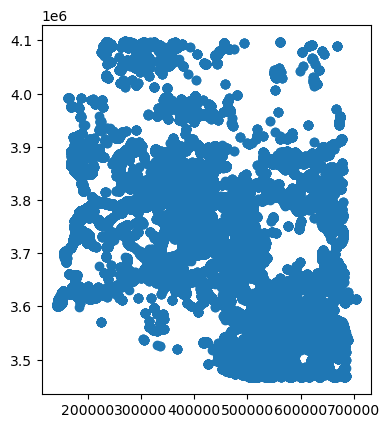

In [21]:
# shallow_wells = static_geo[static_geo['WELL_DEPTH']<200]


shallow_wells = static_geo[
    (static_geo['WELL_DEPTH'] < 200) & 
    (static_geo[Naming_col].notna())
    ]

shallow_wells.plot()

In [22]:
depth_thresholds = [10, 50, 100, 150, 200, 250, 300]
wells_df = static_geo.copy()
summary_df = pd.DataFrame()
grouping_column = Naming_col

for threshold in depth_thresholds:
    summary_df[f"Depth ≤ {threshold} ft"] = (
        wells_df[
            (wells_df["WELL_DEPTH"] <= threshold)
            #   & 
            # (wells_df["DTW_m"] < 10)
        ]
        .groupby(grouping_column)
        .size()
    )

summary_df.fillna(0, inplace=True)  # Replace NaN with 0 for HUCs with no wells meeting criteria
summary_df

,Depth ≤ 10 ft,Depth ≤ 50 ft,Depth ≤ 100 ft,Depth ≤ 150 ft,Depth ≤ 200 ft,Depth ≤ 250 ft,Depth ≤ 300 ft
huc12,,,,,,,
140700060505,1,11,11,11,11,11,11
140700060612,2,2,2,2,2,2,2
140700060905,67,235,239,239,239,239,244
140700061008,6,6,6,6,6,6,6
140700061105,44,70,104,104,127,145,145
...,...,...,...,...,...,...,...
150803020104,102,110,137,150,150,167,173
150803020204,4,18,18,23,25,26,29
150803020205,27,64,64,81,81,98,103


In [25]:
# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('Combo_ID', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134830 entries, 0 to 1134829
Columns: 1426 entries, Combo_ID to fcode
dtypes: float64(1421), int32(1), int64(1), object(3)
memory usage: 12.1+ GB


In [26]:
combo

,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2024-06,2024-07,2024-08,2024-09,nan,huc12,WELL_DEPTH,WELL_TYPE_,reachcode,fcode
Combo_ID,,,,,,,,,,,,,,,,,,,,,
60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150701020705,1000.00,NON-EXEMPT,15070102005283,46007
60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150701020705,1000.00,NON-EXEMPT,15070102005190,46007
60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150701020705,1000.00,NON-EXEMPT,15070102005157,46007
60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150701020705,1000.00,NON-EXEMPT,15070102005160,46007
60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150701020705,1000.00,NON-EXEMPT,15070102005123,46007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1112.00,150503020201,155.00,NON-EXEMPT,15050302000375,46003
627561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1112.00,150503020201,155.00,NON-EXEMPT,15050302000375,46003
627561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1112.00,150503020201,155.00,NON-EXEMPT,15050302000373,46003


In [24]:
wells_df = combo.copy()
wells_df = wells_df.reset_index()
wells_df = wells_df.drop(['WELL_TYPE_'],axis=1)

# Convert from wide format (years as columns) to long format (Year, DTW values)
df_long = wells_df.melt(id_vars=["Combo_ID", "huc4", "WELL_DEPTH"], 
                         var_name="Year", value_name="DTW_ft")

# Convert Year to integer if needed
df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")

# Define the decades of interest
# decades = list(range(1980, df_long["Year"].max() + 1, 10))

# Create an empty summary DataFrame
summary_df = pd.DataFrame()

# Loop through depth thresholds and count wells per HUC
for threshold in depth_thresholds:
    summary_df[f"Depth ≤ {threshold} ft"] = (
        df_long[
            (df_long["WELL_DEPTH"] <= threshold) & 
            (df_long["DTW_ft"] <= 32.8) & # Filtering shallow groundwater (less than 10m)
            (df_long['Year'] >= 1980)
        ]
        .groupby("huc4")["Combo_ID"]
        .nunique()  # Count unique well IDs per HUC
    )

# Fill NaNs with 0 (some HUCs may not meet criteria)
summary_df.fillna(0, inplace=True)

# Display the summary table
summary_df = summary_df.iloc[1:,:]
summary_df


,Depth ≤ 10 ft,Depth ≤ 50 ft,Depth ≤ 100 ft,Depth ≤ 150 ft,Depth ≤ 200 ft,Depth ≤ 250 ft,Depth ≤ 300 ft
huc4,,,,,,,
1501,63,150,227,256,284,295,307
1502,56,788,1025,1142,1199,1228,1258
1503,76,1083,1538,1696,1804,1852,1878
1504,77,317,754,900,967,1002,1031
1505,218,887,1388,1701,1919,2100,2186
1506,137,1386,2225,2736,3021,3201,3341
1507,101,691,1121,1452,1633,1762,1890
1508,44,73,90,96,107,113,117


In [30]:
wells_df = combo.copy()
wells_df = wells_df.reset_index()
wells_df = wells_df.drop(['WELL_TYPE_'],axis=1)

# Convert from wide format (years as columns) to long format (Year, DTW values)
df_long = wells_df.melt(id_vars=["Combo_ID", "huc4", "WELL_DEPTH"], 
                         var_name="Year", value_name="DTW_ft")

# Convert Year to integer if needed
df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")

# Define the decades of interest, ensuring they're integers
df_long["Year"] = df_long["Year"].astype("Int64")  # Converts Year column to integer (handles NaNs)
decades = list(range(1980, df_long["Year"].max() + 1, 10))  # Generate decade list

# Create an empty summary DataFrame
summary_df = pd.DataFrame()

# Loop through depth thresholds and count wells per HUC & decade
for threshold in depth_thresholds:
    summary_df[f"Depth ≤ {threshold} ft"] = (
        df_long[
            (df_long["WELL_DEPTH"] <= threshold) & 
            (df_long["DTW_ft"] <= 32.8) &  # Filtering shallow groundwater (less than 10m)
            # (df_long["Year"] >= 1980)  
            (df_long["Year"].isin(decades)) # Keep only the desired decades
            
        ]
        .groupby(["huc4", "Year"])["Combo_ID"]
        .nunique()  # Count unique wells per HUC per decade
    )

# Fill NaNs with 0 (some HUCs may not meet criteria)
summary_df.fillna(0, inplace=True)

# Reset index so HUC and Year (Decade) remain as a MultiIndex
summary_df = summary_df.reset_index().set_index(["huc4", "Year"])

# Display the summary table
# summary_df = summary_df.iloc[1:, :]  # Keep this if you need to drop the first row
summary_df


Depth ≤ 10 ft  Depth ≤ 50 ft  Depth ≤ 100 ft  Depth ≤ 150 ft  \
huc4 Year                                                                 
1501 1990              3              4               9              10   
1502 1990              2             44              51              61   
     2000              1             29              35              39   
     2010              6             22              23              24   
1503 1990              8             64              76              83   
1504 1980              4              6              19              20   
     1990              4              9              19              24   
1505 1980              1              3              19              24   
     1990             14             44              98             129   
     2000             11             54              85             101   
     2010             10             18              40              58   
     2020             10             21              44              60   
1506 1980              5             24              55              70   
     1990              4             47              63              72   
     2000              3             67              97             116   
     2010              5              8              18              22   
     2020              5             10              20              20   
1507 1980              3             23              31              41   
     1990              8             40              52              66   
     2000              2             22              34              41   
     2010              1              3              16              18   
     2020              5              6              17              24   
1508 1990             11             17              24              26   
     2020              4             13              14              15   

           Depth ≤ 200 ft  Depth ≤ 250 ft  Depth ≤ 300 ft  
huc4 Year                                                  
1501 1990              12              12              12  
1502 1990              64              65              66  
     2000              42              42              43  
     2010              24              24              24  
1503 1990              86              88              90  
1504 1980              21              24              24  
     1990              28              28              31  
1505 1980              25              26              27  
     1990             142             168             179  
     2000             117             120             123  
     2010              66              69              72  
     2020              66              69              73  
1506 1980              85              96              97  
     1990              84              89              97  
     2000             120             127             132  
     2010              22              22              22  
     2020              20              22              22  
1507 1980              48              49              50  
     1990              69              75              80  
     2000              46              54              58  
     2010              20              21              21  
     2020              26              26              26  
1508 1990              30              31              32  
     2020              15              15              15

In [27]:
# Filter by drilling depth
test = combo.copy()
# test["WELL_DEPTH"] = test["WELL_DEPTH"].astype("float64")  # Converts column to integer (handles NaNs)
test = test[test['WELL_DEPTH']<=200]
# test['WELL_DEPTH'].unique()
test


,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2024-06,2024-07,2024-08,2024-09,nan,huc12,WELL_DEPTH,WELL_TYPE_,reachcode,fcode
Combo_ID,,,,,,,,,,,,,,,,,,,,,
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150503010506,101.00,NON-EXEMPT,15050301000081,46003
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150503010506,101.00,NON-EXEMPT,15050301000081,46003
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150503010506,101.00,NON-EXEMPT,15050301000081,46003
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150503010506,101.00,NON-EXEMPT,15050301000081,46003
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150503010506,101.00,NON-EXEMPT,15050301001404,46003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1112.00,150503020201,155.00,NON-EXEMPT,15050302000375,46003
627561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1112.00,150503020201,155.00,NON-EXEMPT,15050302000375,46003
627561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1112.00,150503020201,155.00,NON-EXEMPT,15050302000373,46003


In [28]:
# Grouping the appropriate column
# combo_copy = combo.copy()
combo_copy = test.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_','nan','reachcode','fcode'],axis=1)
# cat_wl = combo_copy.groupby([Naming_col+"_right"]).mean()
cat_wl = combo_copy.groupby([Naming_col]).mean()
cat_wl_median = combo_copy.groupby([Naming_col]).median()

In [42]:
# Clean up the dataframe for graphing
# cat_wl2 = cat_wl.copy()
cat_wl2 = cat_wl_median
i = cat_wl2
# del i['WELL_DEPTH']
f = i.transpose()
f.reset_index(inplace=True)
# Do this bit if you're reading in months
# Setting the date column to datetime
f['index'] = pd.to_datetime(f['index'], format='%Y-%m')
f['index'] = f['index'].dt.tz_localize(None)
f

# Do this bit if you're doing years
# f['index'] = pd.to_numeric(f['index'])
# f['index'] = f['index'].astype(int)


f.set_index('index', inplace=True)
f.info()
cat_wl2 = f
cat_wl2

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1419 entries, 1853-12-01 to 2024-09-01
Columns: 1607 entries, 140700060505 to 150803020404
dtypes: float64(1607)
memory usage: 17.4 MB


huc12,140700060505,140700060612,140700060905,140700061008,140700061105,140700070706,140802041103,140802041104,150100010106,150100010107,...,150803011004,150803020102,150803020103,150803020104,150803020204,150803020205,150803020206,150803020402,150803020403,150803020404
index,,,,,,,,,,,,,,,,,,,,,
1853-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1856-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1857-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1860-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1864-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analysis and Graphing

In [54]:
# Run this code if doing yearly
Min_year_of_Study = 1980
Max_year_of_Study = 2024

# Run this code if doing monthly
Min_year_of_Study = pd.Timestamp("1980-01")
Max_year_of_Study = pd.Timestamp("2024-12")

# Water Analysis period
wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=Max_year_of_Study)]


wlanalysis_period.head(25)

huc12,140700060505,140700060612,140700060905,140700061008,140700061105,140700070706,140802041103,140802041104,150100010106,150100010107,...,150803011004,150803020102,150803020103,150803020104,150803020204,150803020205,150803020206,150803020402,150803020403,150803020404
index,,,,,,,,,,,,,,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,29.40,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


If you are using a lot of HUC's, this code will drop columns if all values are NaN

In [55]:
# wlanalysis_period = wlanalysis_period.dropna(axis=1, how='all')

# This one drops if 90% of values are empty
wlanalysis_period = wlanalysis_period.dropna(axis=1, thresh=int(0.1 * len(wlanalysis_period)))

In [56]:
wlanalysis_period

huc12,150100070107,150100070108,150100070110,150100100208,150100100312,150200010103,150200010107,150200010201,150200010202,150200010203,...,150701040707,150702011302,150702011303,150702011502,150702011504,150702011505,150803010305,150803010307,150803010310,150803010407
index,,,,,,,,,,,,,,,,,,,,,
1980-01-01,NaN,NaN,NaN,10.00,10.00,NaN,55.00,NaN,NaN,28.00,...,130.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,22.64,22.64,NaN,NaN,NaN,NaN
1980-03-01,144.20,144.20,84.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-01,135.65,149.20,122.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.00,14.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,18.00,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-01,NaN,NaN,NaN,NaN,NaN,NaN,11.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
wlanalysis_period.columns

Index(['140700060505', '140700060905', '140700061008', '140700061105',
       '140700070706', '140802041103', '140802041104', '150100010302',
       '150100010303', '150100010306',
       ...
       '150803011004', '150803020102', '150803020103', '150803020104',
       '150803020204', '150803020205', '150803020206', '150803020402',
       '150803020403', '150803020404'],
      dtype='object', name='huc12', length=1288)

This is helpful if you're missing values and it won't calculate statistics

In [81]:
# df_interpolated = wlanalysis_period.interpolate(method='linear', axis=0)
# df_interpolated

         1501    1502    1503    1504    1505    1506    1507  1508
slope     NaN    0.36    0.12    0.51    0.09    0.41    0.46   NaN
int       NaN -694.61 -201.21 -973.02 -149.97 -786.44 -858.75   NaN
rsq       NaN    0.10    0.01    0.28    0.02    0.38    0.12   NaN
p_val     NaN    0.04    0.53    0.00    0.32    0.00    0.02   NaN
std_err   NaN    0.17    0.18    0.12    0.09    0.08    0.18   NaN
mean      NaN   28.87   30.39   39.06   37.81   30.42   55.52   NaN
var       NaN  222.63  243.56  155.84   63.94   74.05  282.20   NaN
sum       NaN 1299.28 1367.39 1757.60 1701.29 1368.90 2498.37   NaN


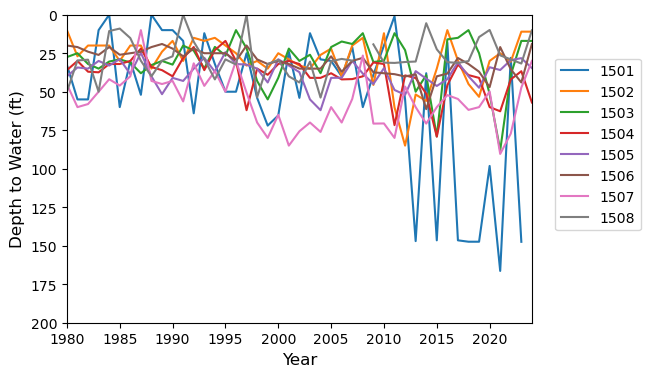

In [83]:
# Define dataset
ds = wlanalysis_period[['1501','1502','1503','1504','1505','1506','1507','1508']]
min_yr = 1980
mx_yr = 2024
Name = "mean_"+StudyArea

betterlabels = ['1501','1502','1503','1504','1505','1506','1507','1508']  # Fixed duplicate '1505'

ylim = 200

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
column_list = ds.columns.tolist()

stats = pd.DataFrame()

for col in column_list:
    df = f[col]
    y = np.array(df.values, dtype=float)
    x = np.array(df.index.values, dtype=float)  # Keeping as float for linregress

    # Calculate linear regression stats
    slope, intercept, r_value, p_value, std_err = sp.linregress(x, y)
    
    # Append statistics to dataframe
    stats = stats._append({
        'slope': slope, 
        'int': intercept, 
        'rsq': r_value * r_value, 
        'p_val': p_value, 
        'std_err': std_err, 
        'mean': np.mean(y),
        'var': np.var(y),
        'sum': np.sum(y)
    }, ignore_index=True)

stats.index = betterlabels
stats1 = stats.transpose()
print(stats1)

fig, ax = plt.subplots(figsize=(6, 4))

# ---- Plot Each Column ----
for i, col in enumerate(column_list):
    x_vals = np.linspace(min_yr, mx_yr, 100)
    m = round(stats1.loc['slope', betterlabels[i]], 2)
    y_int = round(stats1.loc['int', betterlabels[i]], 2)
    y_vals = (m * x_vals) + y_int

    ax.plot(ds[col], label=betterlabels[i]
            # , color='blue'
            )  # Adjust color as needed)
    
# ax.plot(x_vals, y_vals, "-.", color='k', label='Linear Trendline', lw=1)

# Formatting
ax.set_ylim(ylim,0)
ax.set_xticks(np.arange(min_yr, mx_yr + 1, 5))
ax.set_xlim(min_yr, mx_yr)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Depth to Water (ft)', fontsize=12)
ax.legend(loc=[1.05,0.3])


         1501    1502    1503    1504    1505    1506    1507  1508
slope     NaN    0.36    0.12    0.51    0.09    0.41    0.46   NaN
int       NaN -694.61 -201.21 -973.02 -149.97 -786.44 -858.75   NaN
rsq       NaN    0.10    0.01    0.28    0.02    0.38    0.12   NaN
p_val     NaN    0.04    0.53    0.00    0.32    0.00    0.02   NaN
std_err   NaN    0.17    0.18    0.12    0.09    0.08    0.18   NaN
mean      NaN   28.87   30.39   39.06   37.81   30.42   55.52   NaN
var       NaN  222.63  243.56  155.84   63.94   74.05  282.20   NaN
sum       NaN 1299.28 1367.39 1757.60 1701.29 1368.90 2498.37   NaN


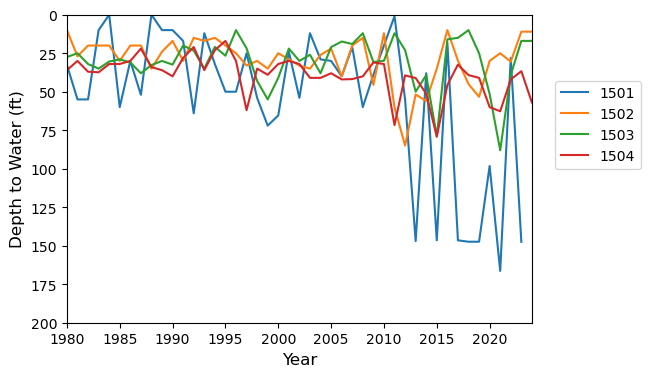

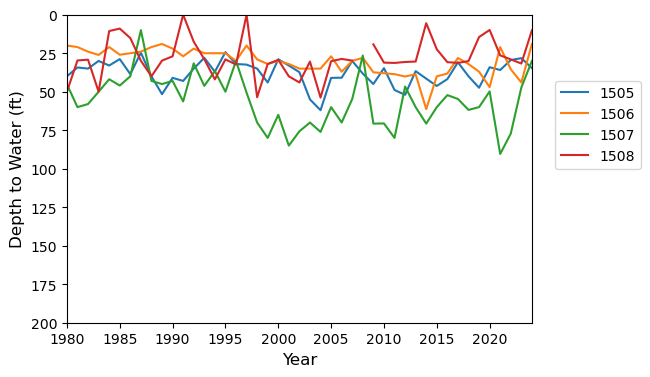

In [87]:
# Define dataset
ds = wlanalysis_period[['1501','1502','1503','1504','1505','1506','1507','1508']]
min_yr = 1980
mx_yr = 2024
Name = "mean_" + StudyArea

betterlabels = ['1501','1502','1503','1504','1505','1506','1507','1508']

ylim = 200

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
column_list = ds.columns.tolist()

stats = pd.DataFrame()

# Compute statistics
for col in column_list:
    df = f[col]
    y = np.array(df.values, dtype=float)
    x = np.array(df.index.values, dtype=float)  

    # Linear regression stats
    slope, intercept, r_value, p_value, std_err = sp.linregress(x, y)

    # Append statistics
    stats = stats._append({
        'slope': slope, 
        'int': intercept, 
        'rsq': r_value * r_value, 
        'p_val': p_value, 
        'std_err': std_err, 
        'mean': np.mean(y),
        'var': np.var(y),
        'sum': np.sum(y)
    }, ignore_index=True)

stats.index = betterlabels
stats1 = stats.transpose()
print(stats1)

# ---- Plot in Groups of 4 ----
batch_size = 4
for i in range(0, len(column_list), batch_size):
    fig, ax = plt.subplots(figsize=(6, 4))

    for col in column_list[i:i+batch_size]:  # Select four at a time
        ax.plot(ds[col], label=col)  
    
    # Formatting
    ax.set_ylim(ylim, 0)
    ax.set_xticks(np.arange(min_yr, mx_yr + 1, 5))
    ax.set_xlim(min_yr, mx_yr)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Depth to Water (ft)', fontsize=12)
    ax.legend(loc=[1.05,0.5])

    # Show each figure before saving
    plt.show()


         150100070107  150100070108  150100070110  150100100208  150100100312  \
slope             NaN           NaN           NaN           NaN           NaN   
int               NaN           NaN           NaN           NaN           NaN   
rsq               NaN           NaN           NaN           NaN           NaN   
p_val             NaN           NaN           NaN           NaN           NaN   
std_err           NaN           NaN           NaN           NaN           NaN   
mean              NaN           NaN           NaN           NaN           NaN   
var               NaN           NaN           NaN           NaN           NaN   
sum               NaN           NaN           NaN           NaN           NaN   

         150200010103  150200010107  150200010201  150200010202  150200010203  \
slope             NaN           NaN           NaN           NaN           NaN   
int               NaN           NaN           NaN           NaN           NaN   
rsq               NaN      

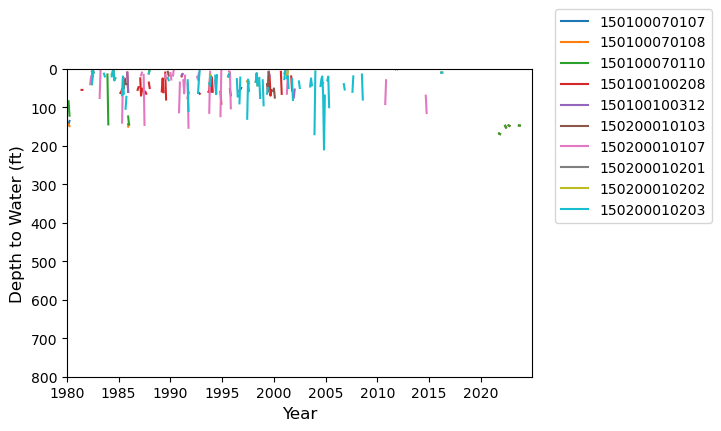

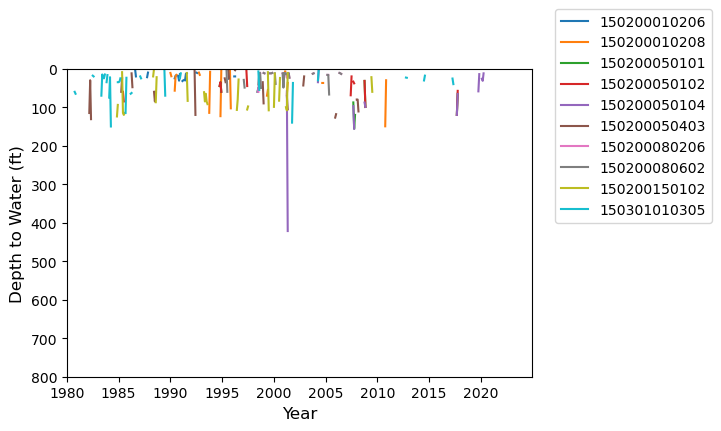

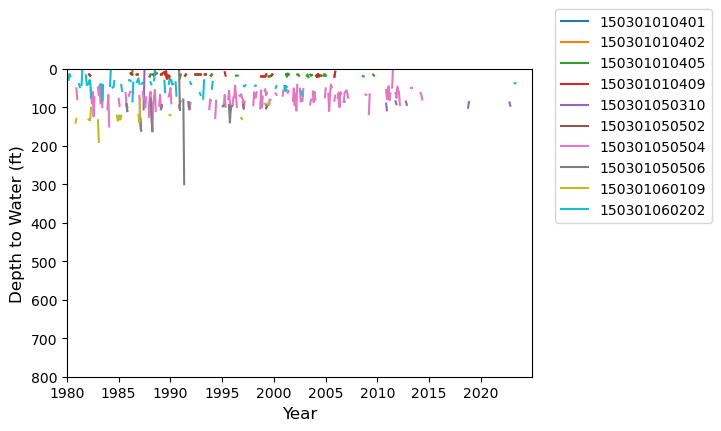

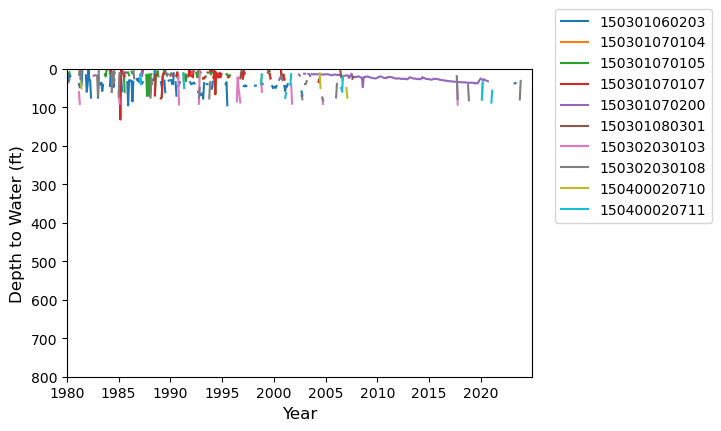

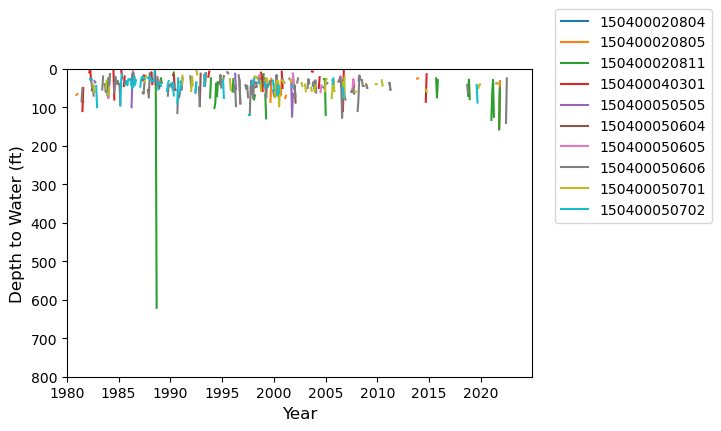

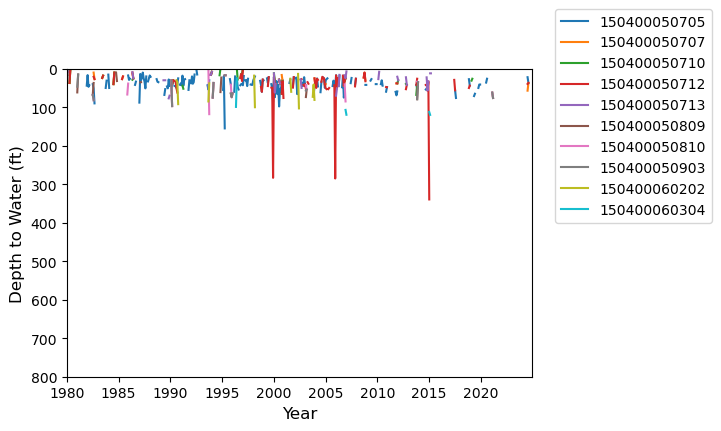

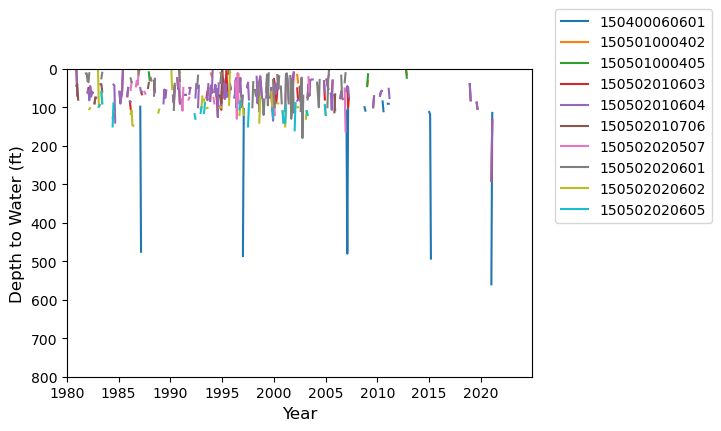

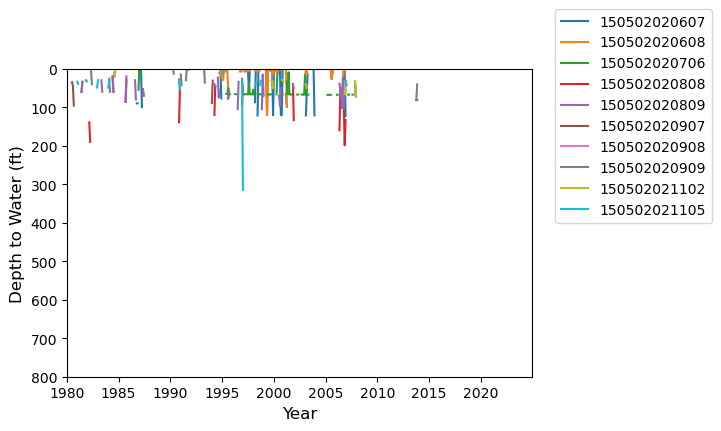

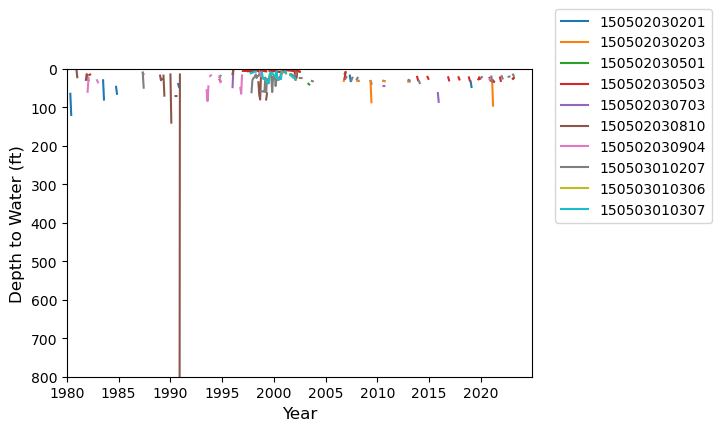

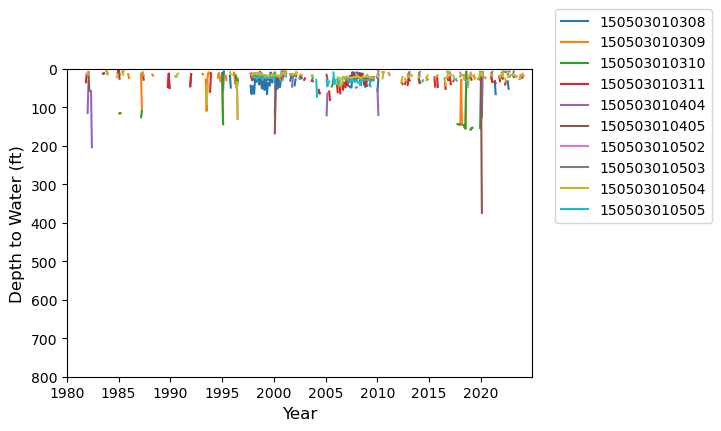

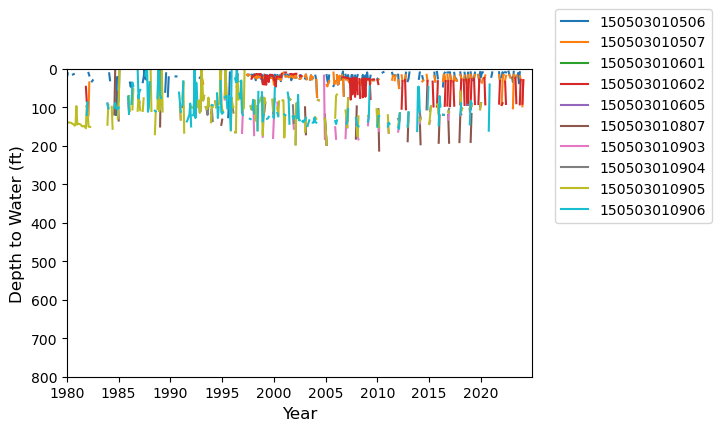

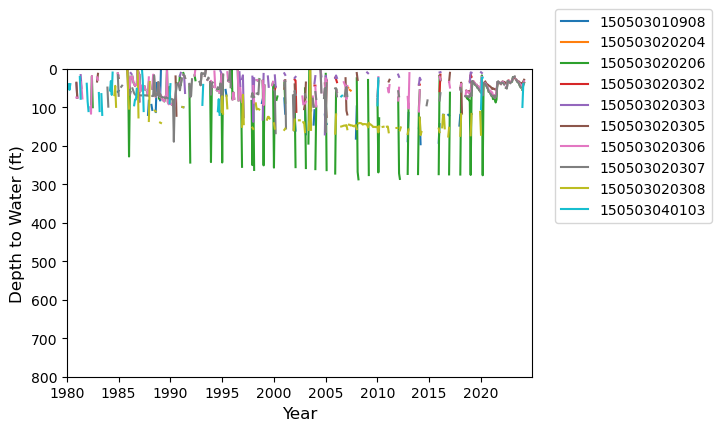

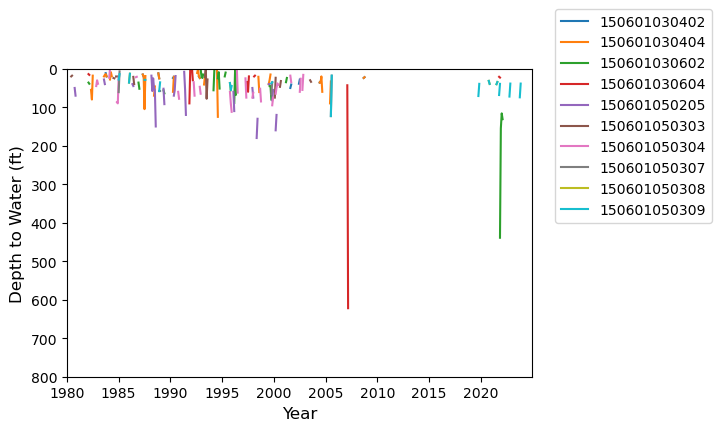

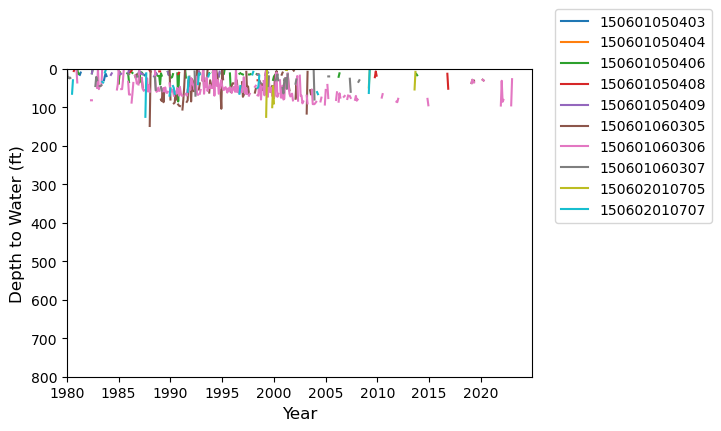

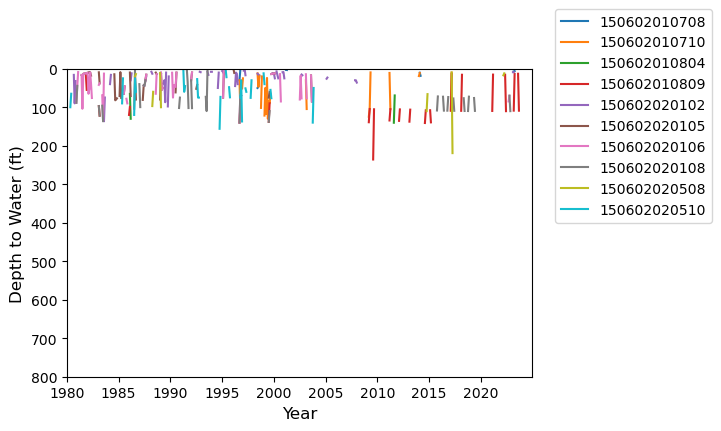

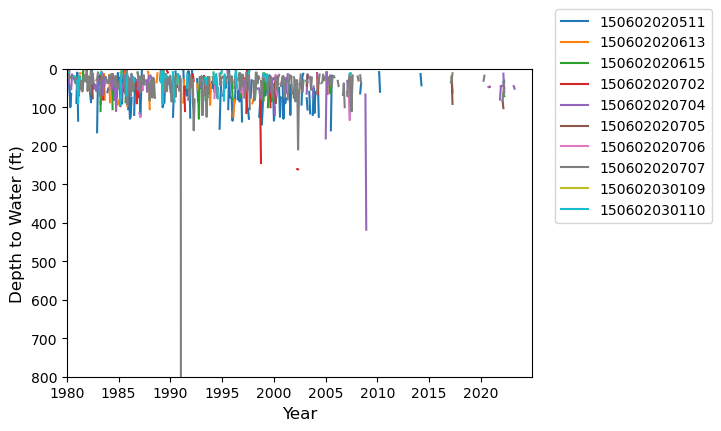

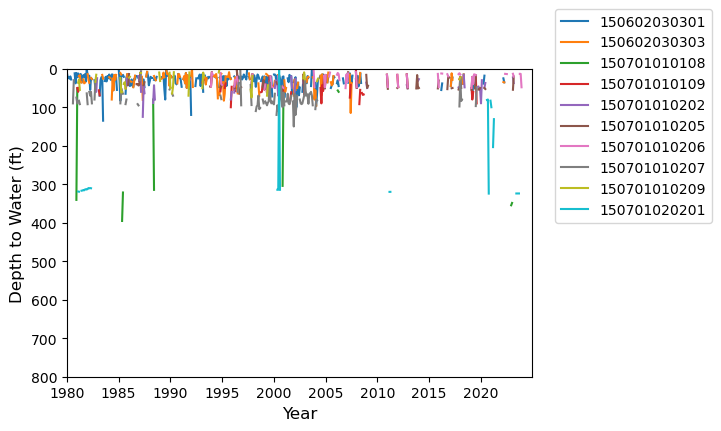

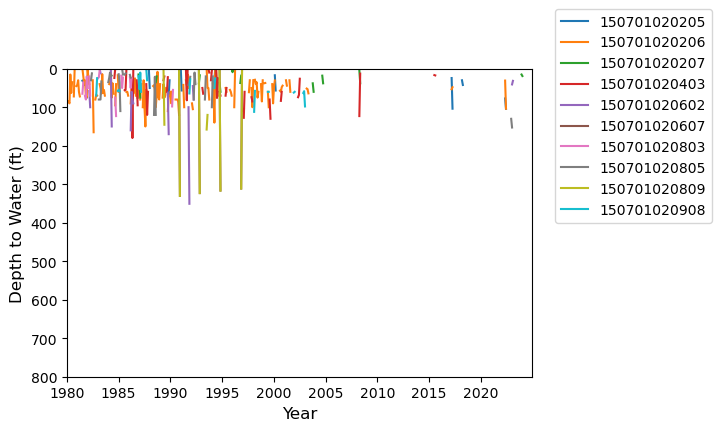

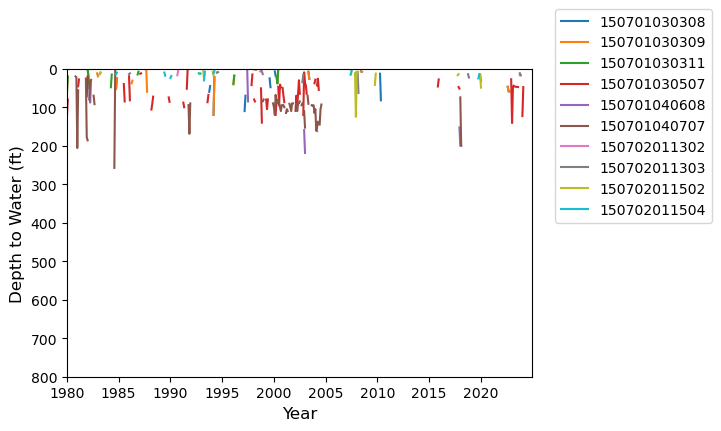

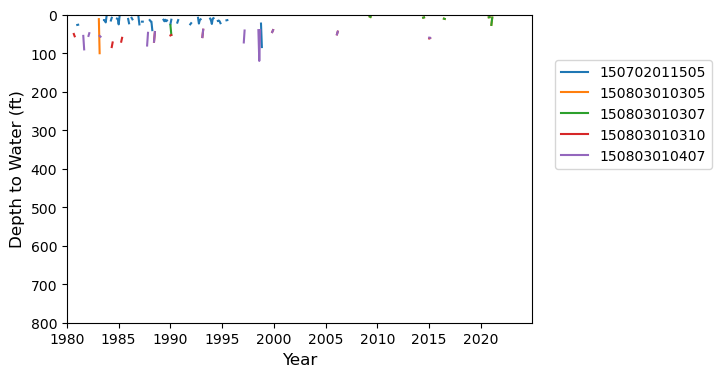

In [60]:
# Define dataset
# ds = wlanalysis_period[['1501','1502','1503','1504','1505','1506','1507','1508']]
ds = wlanalysis_period.copy()
min_yr = Min_year_of_Study
mx_yr = Max_year_of_Study
Name = "median_" + StudyArea

# betterlabels = ['1501','1502','1503','1504','1505','1506','1507','1508']
betterlabels = ds.columns.tolist()

ylim = 800

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
column_list = ds.columns.tolist()

stats = pd.DataFrame()

# Compute statistics
for col in column_list:
    df = f[col]
    y = np.array(df.values, dtype=float)
    x = np.array(df.index.values, dtype=float)  

    # Linear regression stats
    slope, intercept, r_value, p_value, std_err = sp.linregress(x, y)

    # Append statistics
    stats = stats._append({
        'slope': slope, 
        'int': intercept, 
        'rsq': r_value * r_value, 
        'p_val': p_value, 
        'std_err': std_err, 
        'mean': np.mean(y),
        'var': np.var(y),
        'sum': np.sum(y)
    }, ignore_index=True)

stats.index = betterlabels
stats1 = stats.transpose()
print(stats1)

# ---- Plot in Groups of 4 ----
batch_size = 10
for i in range(0, len(column_list), batch_size):
    fig, ax = plt.subplots(figsize=(6, 4))

    for col in column_list[i:i+batch_size]:  # Select four at a time
        ax.plot(ds[col], label=col)  
    
    # Formatting
    ax.set_ylim(ylim, 0)
    # ax.set_xticks(np.arange(min_yr, mx_yr + 1, 5))
    ax.set_xlim(min_yr, mx_yr)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Depth to Water (ft)', fontsize=12)
    ax.legend(loc=[1.05,0.5])

    # Show each figure before saving
    plt.show()


So now that we know it's working well, let's summarize by decade and attach it to some river shapefiles

In [61]:
# Redoing the Analysis period
Min_year_of_Study = pd.Timestamp("1980-01")
Max_year_of_Study = pd.Timestamp("2024-12")

# Water Analysis period
wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=Max_year_of_Study)]

In [62]:
ds = wlanalysis_period
# Keep only November - March
filtered_df = ds[ds.index.month.isin([11, 12, 1, 2, 3])]


In [63]:
# Create a 'decade' column
filtered_df['decade'] = (filtered_df.index.year // 10) * 10  # Floors year to the nearest decade

# Group by decade and take the mean or median
dtw_per_decade = filtered_df.groupby("decade").median()  # Change to .mean() if needed


/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_1663/3563108762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['decade'] = (filtered_df.index.year // 10) * 10  # Floors year to the nearest decade


In [64]:
dtw_per_decade

huc12,140700060505,140700060612,140700060905,140700061008,140700061105,140700070706,140802041103,140802041104,150100010106,150100010107,...,150803011004,150803020102,150803020103,150803020104,150803020204,150803020205,150803020206,150803020402,150803020403,150803020404
decade,,,,,,,,,,,,,,,,,,,,,
1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,40.00,NaN,29.70,160.00,NaN,NaN,NaN,NaN,NaN
1990,16.00,NaN,8.00,NaN,24.00,24.00,NaN,NaN,NaN,NaN,...,44.00,37.70,286.50,29.00,NaN,7.85,-4.04,NaN,7.52,NaN
2000,NaN,NaN,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN,...,NaN,71.35,NaN,29.92,NaN,0.00,0.00,NaN,9.10,NaN
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.40,NaN,NaN,30.75,NaN,14.50,9.70,NaN,NaN,NaN
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.70,NaN,15.00,14.60,NaN,NaN,NaN


In [65]:
dtw_per_decade = dtw_per_decade.dropna(axis=1, how='all')
dtw_per_decade


huc12,140700060505,140700060905,140700061105,140700070706,150100010303,150100030205,150100030311,150100030505,150100030604,150100030605,...,150803010412,150803011002,150803011004,150803020102,150803020103,150803020104,150803020204,150803020205,150803020206,150803020403
decade,,,,,,,,,,,,,,,,,,,,,
1980,NaN,NaN,NaN,NaN,NaN,NaN,30.00,NaN,51.75,NaN,...,0.00,NaN,NaN,40.00,NaN,29.70,160.00,NaN,NaN,NaN
1990,16.00,8.00,24.00,24.00,0.00,NaN,NaN,12.00,0.00,22.00,...,44.00,27.10,44.00,37.70,286.50,29.00,NaN,7.85,-4.04,7.52
2000,NaN,NaN,5.00,NaN,NaN,10.00,NaN,21.50,NaN,NaN,...,77.35,NaN,NaN,71.35,NaN,29.92,NaN,0.00,0.00,9.10
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.40,25.40,25.40,NaN,NaN,30.75,NaN,14.50,9.70,NaN
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,30.70,NaN,15.00,14.60,NaN


In [66]:
dtw_per_decade = dtw_per_decade.transpose()
dtw_per_decade.reset_index(inplace=True)
dtw_per_decade


decade,huc12,1980,1990,2000,2010,2020
0,140700060505,NaN,16.00,NaN,NaN,NaN
1,140700060905,NaN,8.00,NaN,NaN,NaN
2,140700061105,NaN,24.00,5.00,NaN,NaN
3,140700070706,NaN,24.00,NaN,NaN,NaN
4,150100010303,NaN,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...
1035,150803020104,29.70,29.00,29.92,30.75,30.70
1036,150803020204,160.00,NaN,NaN,NaN,NaN
1037,150803020205,NaN,7.85,0.00,14.50,15.00
1038,150803020206,NaN,-4.04,0.00,9.70,14.60


In [67]:
shapefile.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 159808 entries, 0 to 159807
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   permanent_  159808 non-null  object  
 1   gnis_name   70971 non-null   object  
 2   reachcode   159808 non-null  object  
 3   streamorde  159808 non-null  int32   
 4   ID          13518 non-null   object  
 5   huc12       159808 non-null  object  
 6   huc_name    159808 non-null  object  
 7   fcode       159808 non-null  int32   
 8   geometry    159808 non-null  geometry
dtypes: geometry(1), int32(2), object(6)
memory usage: 9.8+ MB


In [68]:
gdf = shapefile.copy()
# Ensure HUC12 is the same type in both datasets (str is often safest)
gdf["huc12"] = gdf["huc12"].astype(str)
dtw_per_decade["huc12"] = dtw_per_decade["huc12"].astype(str)

# Perform the join (left join to keep all spatial data)
merged_gdf = gdf.merge(dtw_per_decade, on="huc12", how="left")
merged_gdf


,permanent_,gnis_name,reachcode,streamorde,ID,huc12,huc_name,fcode,geometry,1980,1990,2000,2010,2020
0,149136270,Dodson Wash,15020005000065,5,None,150200050309,Dodson Wash,46003,"POLYGON ((569966.028 3801286.701, 569973.709 3...",115.00,NaN,140.00,NaN,NaN
1,149136272,Dodson Wash,15020005000066,5,None,150200050309,Dodson Wash,46003,"POLYGON ((569844.377 3799052.163, 569833.192 3...",115.00,NaN,140.00,NaN,NaN
2,149136273,Dodson Wash,15020005000067,5,None,150200050309,Dodson Wash,46003,"POLYGON ((569867.495 3798595.014, 569864.686 3...",115.00,NaN,140.00,NaN,NaN
3,149136329,Dodson Wash,15020005000068,5,None,150200050309,Dodson Wash,46003,"POLYGON ((569859.96 3797547.077, 569817.76 379...",115.00,NaN,140.00,NaN,NaN
4,149133749,Dodson Wash,15020005000064,5,None,150200050309,Dodson Wash,46003,"POLYGON ((571094.505 3801490.283, 570915.743 3...",115.00,NaN,140.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159803,79070122,Dry Creek,14070007000196,4,None,140700070104,Dry Creek,46003,"POLYGON ((413092.51 4163031.59, 413111.386 416...",NaN,NaN,NaN,NaN,NaN
159804,79070510,Henrieville Creek,14070007000189,4,09381000,140700070105,Henrieville Creek,46006,"POLYGON ((412452.219 4158396.205, 412458.747 4...",NaN,NaN,NaN,NaN,NaN
159805,79070510,Henrieville Creek,14070007000189,4,373549111545201,140700070105,Henrieville Creek,46006,"POLYGON ((412452.219 4158396.205, 412458.747 4...",NaN,NaN,NaN,NaN,NaN
159806,79070510,Henrieville Creek,14070007000189,4,373549111545201,140700070105,Henrieville Creek,46006,"POLYGON ((412452.219 4158396.205, 412458.747 4...",NaN,NaN,NaN,NaN,NaN


In [73]:
if "geometry" not in merged_gdf.columns:
    print("No geometry column detected! Check your shapefile merge.")


In [74]:
merged_gdf.columns = [col[:10] for col in merged_gdf.columns]


TypeError: 'int' object is not subscriptable

In [75]:
# Rename columns to avoid integer-only names
merged_gdf = merged_gdf.rename(columns={col: f"{col}-Decade" for col in merged_gdf.columns if isinstance(col, int)})
merged_gdf

,permanent_,gnis_name,reachcode,streamorde,ID,huc12,huc_name,fcode,geometry,1980-Decade,1990-Decade,2000-Decade,2010-Decade,2020-Decade
0,149136270,Dodson Wash,15020005000065,5,None,150200050309,Dodson Wash,46003,"POLYGON ((569966.028 3801286.701, 569973.709 3...",115.00,NaN,140.00,NaN,NaN
1,149136272,Dodson Wash,15020005000066,5,None,150200050309,Dodson Wash,46003,"POLYGON ((569844.377 3799052.163, 569833.192 3...",115.00,NaN,140.00,NaN,NaN
2,149136273,Dodson Wash,15020005000067,5,None,150200050309,Dodson Wash,46003,"POLYGON ((569867.495 3798595.014, 569864.686 3...",115.00,NaN,140.00,NaN,NaN
3,149136329,Dodson Wash,15020005000068,5,None,150200050309,Dodson Wash,46003,"POLYGON ((569859.96 3797547.077, 569817.76 379...",115.00,NaN,140.00,NaN,NaN
4,149133749,Dodson Wash,15020005000064,5,None,150200050309,Dodson Wash,46003,"POLYGON ((571094.505 3801490.283, 570915.743 3...",115.00,NaN,140.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159803,79070122,Dry Creek,14070007000196,4,None,140700070104,Dry Creek,46003,"POLYGON ((413092.51 4163031.59, 413111.386 416...",NaN,NaN,NaN,NaN,NaN
159804,79070510,Henrieville Creek,14070007000189,4,09381000,140700070105,Henrieville Creek,46006,"POLYGON ((412452.219 4158396.205, 412458.747 4...",NaN,NaN,NaN,NaN,NaN
159805,79070510,Henrieville Creek,14070007000189,4,373549111545201,140700070105,Henrieville Creek,46006,"POLYGON ((412452.219 4158396.205, 412458.747 4...",NaN,NaN,NaN,NaN,NaN
159806,79070510,Henrieville Creek,14070007000189,4,373549111545201,140700070105,Henrieville Creek,46006,"POLYGON ((412452.219 4158396.205, 412458.747 4...",NaN,NaN,NaN,NaN,NaN


In [76]:
merged_gdf.to_file(outputpath+'/huc12bufferedflowlines_MedianDecadalDTW.shp')

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_1663/205197166.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_gdf.to_file(outputpath+'/huc12bufferedflowlines_MedianDecadalDTW.shp')
/Users/danielletadych/opt/miniconda3/envs/Drought_Southwest/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: '1980-Decade' to '1980-Decad'
  ogr_write(
/Users/danielletadych/opt/miniconda3/envs/Drought_Southwest/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: '1990-Decade' to '1990-Decad'
  ogr_write(
/Users/danielletadych/opt/miniconda3/envs/Drought_Southwest/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: '2000-Decade' to '2000-Decad'
  ogr_write(
/Users/danielletadych/opt/miniconda3/envs/Drought_Southwest/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/l

In [70]:
type(StudyArea)

str